In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Dec 29 14:21:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   41C    P8    40W / 250W |   6350MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 41%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 300

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '29December_Tracks_to_Hists_Iteration_3B_300epochs_lr_2em7_2p5_kde2hists_allFloat'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 2e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 26.49 s
outer loop X.shape =  (20000, 9, 600)
Constructing 18000 event dataset took 0.08889 s
x_t.shape =  torch.Size([18000, 9, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  9
x_t.shape =  torch.Size([18000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [11]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '29December_Tracks_to_Hists_Iteration_2B_100epochs_lr_1em7_2p5_kde2hists_allFloat'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [12]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [13]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


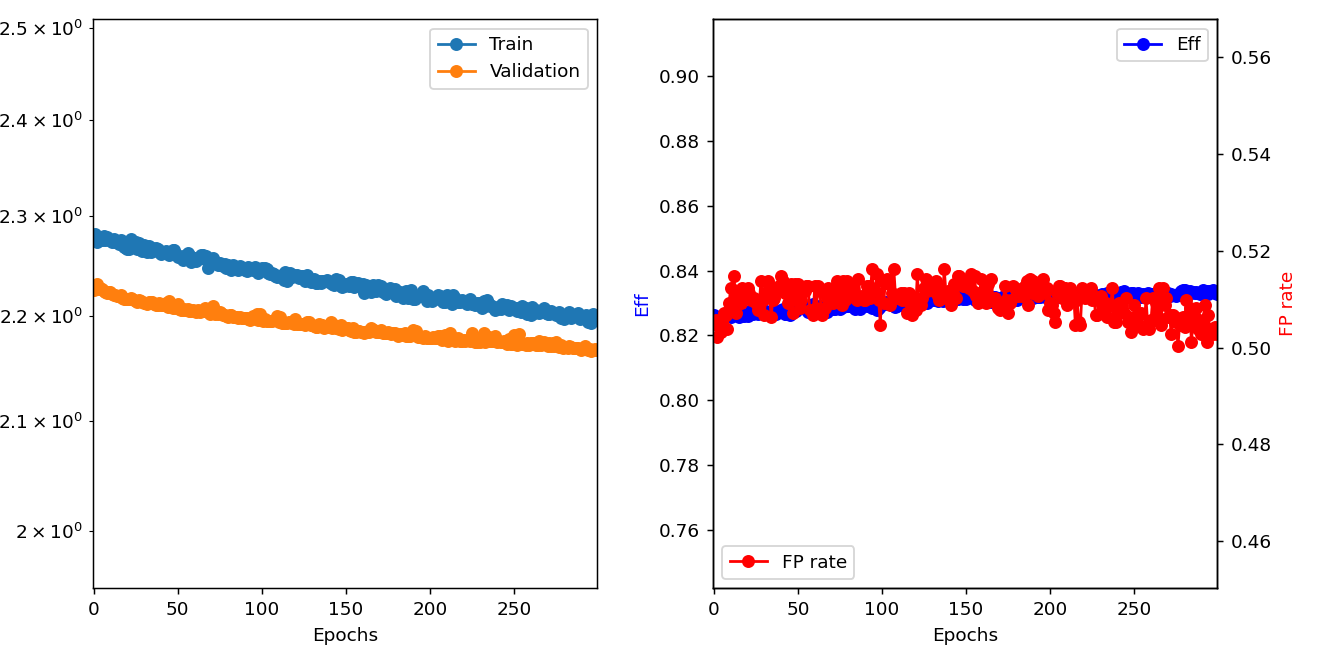

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Epoch 0: train=2.28087, val=2.22606, took 44.292 s
  Validation Found 8938 of 10819, added 1011 (eff 82.61%) (0.505 FP/event)


Epoch 1: train=2.28155, val=2.22651, took 43.379 s
  Validation Found 8919 of 10819, added 1012 (eff 82.44%) (0.506 FP/event)


Epoch 2: train=2.27386, val=2.23174, took 43.752 s
  Validation Found 8934 of 10819, added 1005 (eff 82.58%) (0.502 FP/event)


Epoch 3: train=2.27701, val=2.22635, took 44.045 s
  Validation Found 8930 of 10819, added 1009 (eff 82.54%) (0.504 FP/event)


Epoch 4: train=2.278, val=2.22765, took 44.093 s
  Validation Found 8934 of 10819, added 1007 (eff 82.58%) (0.503 FP/event)


Epoch 5: train=2.27615, val=2.22661, took 44.153 s
  Validation Found 8931 of 10819, added 1011 (eff 82.55%) (0.505 FP/event)


Epoch 6: train=2.27966, val=2.22501, took 44.059 s
  Validation Found 8930 of 10819, added 1015 (eff 82.54%) (0.507 FP/event)


Epoch 7: train=2.27604, val=2.22377, took 44.225 s
  Validation Found 8938 of 10819, added 1014 (eff 82.61%) (0.507 FP/event)


Epoch 8: train=2.27879, val=2.22273, took 44.178 s
  Validation Found 8939 of 10819, added 1008 (eff 82.62%) (0.504 FP/event)


Epoch 9: train=2.27554, val=2.22393, took 44.201 s
  Validation Found 8935 of 10819, added 1019 (eff 82.59%) (0.509 FP/event)


Epoch 10: train=2.27532, val=2.22338, took 44.158 s
  Validation Found 8933 of 10819, added 1025 (eff 82.57%) (0.512 FP/event)


Epoch 11: train=2.27418, val=2.2216, took 44.026 s
  Validation Found 8944 of 10819, added 1018 (eff 82.67%) (0.509 FP/event)


Epoch 12: train=2.27681, val=2.22129, took 44.163 s
  Validation Found 8949 of 10819, added 1030 (eff 82.72%) (0.515 FP/event)


Epoch 13: train=2.27335, val=2.22117, took 44.155 s
  Validation Found 8943 of 10819, added 1015 (eff 82.66%) (0.507 FP/event)


Epoch 14: train=2.27358, val=2.21971, took 44.143 s
  Validation Found 8950 of 10819, added 1022 (eff 82.72%) (0.511 FP/event)


Epoch 15: train=2.2722, val=2.21955, took 44.155 s
  Validation Found 8934 of 10819, added 1024 (eff 82.58%) (0.512 FP/event)


Epoch 16: train=2.27526, val=2.22072, took 44.101 s
  Validation Found 8937 of 10819, added 1019 (eff 82.60%) (0.509 FP/event)


Epoch 17: train=2.27411, val=2.21806, took 44.144 s
  Validation Found 8942 of 10819, added 1025 (eff 82.65%) (0.512 FP/event)


Epoch 18: train=2.26845, val=2.21735, took 43.601 s
  Validation Found 8936 of 10819, added 1021 (eff 82.60%) (0.51 FP/event)


Epoch 19: train=2.2678, val=2.21724, took 44.034 s
  Validation Found 8938 of 10819, added 1021 (eff 82.61%) (0.51 FP/event)


Epoch 20: train=2.26717, val=2.21709, took 43.831 s
  Validation Found 8936 of 10819, added 1025 (eff 82.60%) (0.512 FP/event)


Epoch 21: train=2.26716, val=2.21688, took 43.757 s
  Validation Found 8946 of 10819, added 1023 (eff 82.69%) (0.511 FP/event)


Epoch 22: train=2.27696, val=2.21805, took 43.743 s
  Validation Found 8955 of 10819, added 1020 (eff 82.77%) (0.51 FP/event)


Epoch 23: train=2.26832, val=2.21731, took 43.833 s
  Validation Found 8943 of 10819, added 1020 (eff 82.66%) (0.51 FP/event)


Epoch 24: train=2.26847, val=2.21597, took 43.872 s
  Validation Found 8952 of 10819, added 1021 (eff 82.74%) (0.51 FP/event)


Epoch 25: train=2.27398, val=2.21527, took 43.764 s
  Validation Found 8948 of 10819, added 1019 (eff 82.71%) (0.509 FP/event)


Epoch 26: train=2.26639, val=2.21449, took 43.794 s
  Validation Found 8943 of 10819, added 1016 (eff 82.66%) (0.508 FP/event)


Epoch 27: train=2.27225, val=2.21557, took 43.835 s
  Validation Found 8952 of 10819, added 1019 (eff 82.74%) (0.509 FP/event)


Epoch 28: train=2.26534, val=2.21474, took 43.57 s
  Validation Found 8949 of 10819, added 1028 (eff 82.72%) (0.514 FP/event)


Epoch 29: train=2.26491, val=2.21433, took 43.933 s
  Validation Found 8950 of 10819, added 1020 (eff 82.72%) (0.51 FP/event)


Epoch 30: train=2.27072, val=2.21328, took 43.935 s
  Validation Found 8952 of 10819, added 1014 (eff 82.74%) (0.507 FP/event)


Epoch 31: train=2.26942, val=2.21332, took 43.754 s
  Validation Found 8954 of 10819, added 1023 (eff 82.76%) (0.511 FP/event)


Epoch 32: train=2.26336, val=2.21251, took 44.055 s
  Validation Found 8950 of 10819, added 1028 (eff 82.72%) (0.514 FP/event)


Epoch 33: train=2.26941, val=2.21358, took 43.656 s
  Validation Found 8943 of 10819, added 1025 (eff 82.66%) (0.512 FP/event)


Epoch 34: train=2.26412, val=2.21393, took 44.028 s
  Validation Found 8947 of 10819, added 1013 (eff 82.70%) (0.506 FP/event)


Epoch 35: train=2.26799, val=2.21372, took 44.041 s
  Validation Found 8947 of 10819, added 1020 (eff 82.70%) (0.51 FP/event)


Epoch 36: train=2.26539, val=2.21161, took 44.154 s
  Validation Found 8951 of 10819, added 1021 (eff 82.73%) (0.51 FP/event)


Epoch 37: train=2.26765, val=2.21066, took 43.981 s
  Validation Found 8943 of 10819, added 1025 (eff 82.66%) (0.512 FP/event)


Epoch 38: train=2.26623, val=2.21125, took 43.807 s
  Validation Found 8954 of 10819, added 1025 (eff 82.76%) (0.512 FP/event)


Epoch 39: train=2.26363, val=2.21297, took 43.87 s
  Validation Found 8950 of 10819, added 1026 (eff 82.72%) (0.513 FP/event)


Epoch 40: train=2.26186, val=2.21144, took 44.088 s
  Validation Found 8956 of 10819, added 1030 (eff 82.78%) (0.515 FP/event)


Epoch 41: train=2.26325, val=2.21067, took 44.005 s
  Validation Found 8961 of 10819, added 1028 (eff 82.83%) (0.514 FP/event)


Epoch 42: train=2.26401, val=2.21172, took 44.009 s
  Validation Found 8944 of 10819, added 1023 (eff 82.67%) (0.511 FP/event)


Epoch 43: train=2.26478, val=2.21256, took 44.009 s
  Validation Found 8942 of 10819, added 1025 (eff 82.65%) (0.512 FP/event)


Epoch 44: train=2.26327, val=2.20874, took 43.731 s
  Validation Found 8951 of 10819, added 1019 (eff 82.73%) (0.509 FP/event)


Epoch 45: train=2.26102, val=2.21482, took 43.984 s
  Validation Found 8941 of 10819, added 1021 (eff 82.64%) (0.51 FP/event)


Epoch 46: train=2.26302, val=2.2103, took 43.948 s
  Validation Found 8949 of 10819, added 1027 (eff 82.72%) (0.513 FP/event)


Epoch 47: train=2.26525, val=2.20845, took 43.992 s
  Validation Found 8958 of 10819, added 1015 (eff 82.80%) (0.507 FP/event)


Epoch 48: train=2.26558, val=2.20897, took 44.12 s
  Validation Found 8964 of 10819, added 1027 (eff 82.85%) (0.513 FP/event)


Epoch 49: train=2.26159, val=2.20853, took 44.116 s
  Validation Found 8954 of 10819, added 1020 (eff 82.76%) (0.51 FP/event)


Epoch 50: train=2.25865, val=2.21186, took 43.918 s
  Validation Found 8969 of 10819, added 1027 (eff 82.90%) (0.513 FP/event)


Epoch 51: train=2.25987, val=2.20757, took 43.764 s
  Validation Found 8966 of 10819, added 1017 (eff 82.87%) (0.508 FP/event)


Epoch 52: train=2.25898, val=2.20641, took 43.898 s
  Validation Found 8964 of 10819, added 1020 (eff 82.85%) (0.51 FP/event)


Epoch 53: train=2.25551, val=2.20645, took 43.952 s
  Validation Found 8963 of 10819, added 1025 (eff 82.84%) (0.512 FP/event)


Epoch 54: train=2.25982, val=2.20672, took 43.795 s
  Validation Found 8960 of 10819, added 1024 (eff 82.82%) (0.512 FP/event)


Epoch 55: train=2.26066, val=2.20585, took 43.926 s
  Validation Found 8966 of 10819, added 1026 (eff 82.87%) (0.513 FP/event)


Epoch 56: train=2.26275, val=2.20683, took 43.839 s
  Validation Found 8948 of 10819, added 1026 (eff 82.71%) (0.513 FP/event)


Epoch 57: train=2.26082, val=2.20554, took 44.087 s
  Validation Found 8964 of 10819, added 1016 (eff 82.85%) (0.508 FP/event)


Epoch 58: train=2.25369, val=2.20554, took 43.935 s
  Validation Found 8965 of 10819, added 1016 (eff 82.86%) (0.508 FP/event)


Epoch 59: train=2.25758, val=2.20596, took 43.868 s
  Validation Found 8975 of 10819, added 1014 (eff 82.96%) (0.507 FP/event)


Epoch 60: train=2.25763, val=2.20527, took 44.037 s
  Validation Found 8969 of 10819, added 1026 (eff 82.90%) (0.513 FP/event)


Epoch 61: train=2.25511, val=2.20471, took 43.892 s
  Validation Found 8966 of 10819, added 1017 (eff 82.87%) (0.508 FP/event)


Epoch 62: train=2.25679, val=2.20578, took 44.013 s
  Validation Found 8959 of 10819, added 1026 (eff 82.81%) (0.513 FP/event)


Epoch 63: train=2.25727, val=2.20381, took 44.034 s
  Validation Found 8969 of 10819, added 1024 (eff 82.90%) (0.512 FP/event)


Epoch 64: train=2.26069, val=2.20531, took 43.745 s
  Validation Found 8965 of 10819, added 1014 (eff 82.86%) (0.507 FP/event)


Epoch 65: train=2.26057, val=2.20529, took 43.95 s
  Validation Found 8954 of 10819, added 1016 (eff 82.76%) (0.508 FP/event)


Epoch 66: train=2.25622, val=2.20828, took 43.93 s
  Validation Found 8961 of 10819, added 1017 (eff 82.83%) (0.508 FP/event)


Epoch 67: train=2.25963, val=2.20474, took 43.737 s
  Validation Found 8950 of 10819, added 1021 (eff 82.72%) (0.51 FP/event)


Epoch 68: train=2.24739, val=2.20453, took 43.826 s
  Validation Found 8959 of 10819, added 1025 (eff 82.81%) (0.512 FP/event)


Epoch 69: train=2.25173, val=2.20272, took 43.864 s
  Validation Found 8960 of 10819, added 1020 (eff 82.82%) (0.51 FP/event)


Epoch 70: train=2.25227, val=2.2084, took 44.129 s
  Validation Found 8962 of 10819, added 1022 (eff 82.84%) (0.511 FP/event)


Epoch 71: train=2.2579, val=2.21034, took 43.702 s
  Validation Found 8959 of 10819, added 1019 (eff 82.81%) (0.509 FP/event)


Epoch 72: train=2.25344, val=2.20264, took 44.024 s
  Validation Found 8961 of 10819, added 1024 (eff 82.83%) (0.512 FP/event)


Epoch 73: train=2.25386, val=2.20327, took 43.86 s
  Validation Found 8977 of 10819, added 1028 (eff 82.97%) (0.514 FP/event)


Epoch 74: train=2.25089, val=2.20207, took 43.933 s
  Validation Found 8972 of 10819, added 1024 (eff 82.93%) (0.512 FP/event)


Epoch 75: train=2.25235, val=2.20391, took 44.063 s
  Validation Found 8960 of 10819, added 1021 (eff 82.82%) (0.51 FP/event)


Epoch 76: train=2.25022, val=2.20325, took 44.025 s
  Validation Found 8978 of 10819, added 1018 (eff 82.98%) (0.509 FP/event)


Epoch 77: train=2.24974, val=2.20125, took 43.704 s
  Validation Found 8965 of 10819, added 1028 (eff 82.86%) (0.514 FP/event)


Epoch 78: train=2.2517, val=2.20115, took 43.861 s
  Validation Found 8968 of 10819, added 1020 (eff 82.89%) (0.51 FP/event)


Epoch 79: train=2.24791, val=2.20002, took 44.202 s
  Validation Found 8971 of 10819, added 1028 (eff 82.92%) (0.514 FP/event)


Epoch 80: train=2.25046, val=2.19979, took 43.765 s
  Validation Found 8971 of 10819, added 1025 (eff 82.92%) (0.512 FP/event)


Epoch 81: train=2.24967, val=2.20091, took 43.874 s
  Validation Found 8970 of 10819, added 1023 (eff 82.91%) (0.511 FP/event)


Epoch 82: train=2.24565, val=2.20116, took 43.977 s
  Validation Found 8975 of 10819, added 1022 (eff 82.96%) (0.511 FP/event)


Epoch 83: train=2.25049, val=2.19928, took 43.564 s
  Validation Found 8965 of 10819, added 1026 (eff 82.86%) (0.513 FP/event)


Epoch 84: train=2.24723, val=2.1998, took 43.947 s
  Validation Found 8961 of 10819, added 1021 (eff 82.83%) (0.51 FP/event)


Epoch 85: train=2.24661, val=2.19931, took 43.565 s
  Validation Found 8970 of 10819, added 1020 (eff 82.91%) (0.51 FP/event)


Epoch 86: train=2.24578, val=2.1987, took 43.775 s
  Validation Found 8963 of 10819, added 1029 (eff 82.84%) (0.514 FP/event)


Epoch 87: train=2.24935, val=2.19921, took 44.006 s
  Validation Found 8961 of 10819, added 1021 (eff 82.83%) (0.51 FP/event)


Epoch 88: train=2.24775, val=2.19843, took 43.718 s
  Validation Found 8968 of 10819, added 1022 (eff 82.89%) (0.511 FP/event)


Epoch 89: train=2.24767, val=2.19822, took 43.929 s
  Validation Found 8973 of 10819, added 1020 (eff 82.94%) (0.51 FP/event)


Epoch 90: train=2.24551, val=2.19789, took 43.8 s
  Validation Found 8972 of 10819, added 1020 (eff 82.93%) (0.51 FP/event)


Epoch 91: train=2.2448, val=2.19868, took 43.774 s
  Validation Found 8970 of 10819, added 1026 (eff 82.91%) (0.513 FP/event)


Epoch 92: train=2.24908, val=2.19725, took 44.085 s
  Validation Found 8981 of 10819, added 1026 (eff 83.01%) (0.513 FP/event)


Epoch 93: train=2.24631, val=2.19683, took 44.039 s
  Validation Found 8979 of 10819, added 1021 (eff 82.99%) (0.51 FP/event)


Epoch 94: train=2.24701, val=2.1976, took 43.836 s
  Validation Found 8963 of 10819, added 1033 (eff 82.84%) (0.516 FP/event)


Epoch 95: train=2.2452, val=2.20027, took 43.772 s
  Validation Found 8973 of 10819, added 1024 (eff 82.94%) (0.512 FP/event)


Epoch 96: train=2.24838, val=2.19792, took 43.912 s
  Validation Found 8968 of 10819, added 1024 (eff 82.89%) (0.512 FP/event)


Epoch 97: train=2.24461, val=2.20272, took 43.85 s
  Validation Found 8956 of 10819, added 1031 (eff 82.78%) (0.515 FP/event)


Epoch 98: train=2.24295, val=2.19654, took 44.041 s
  Validation Found 8964 of 10819, added 1020 (eff 82.85%) (0.51 FP/event)


Epoch 99: train=2.24512, val=2.20271, took 44.069 s
  Validation Found 8988 of 10819, added 1010 (eff 83.08%) (0.505 FP/event)


Epoch 100: train=2.24775, val=2.19659, took 43.983 s
  Validation Found 8973 of 10819, added 1028 (eff 82.94%) (0.514 FP/event)


Epoch 101: train=2.24659, val=2.19509, took 44.099 s
  Validation Found 8980 of 10819, added 1019 (eff 83.00%) (0.509 FP/event)


Epoch 102: train=2.24788, val=2.1971, took 44.083 s
  Validation Found 8975 of 10819, added 1028 (eff 82.96%) (0.514 FP/event)


Epoch 103: train=2.24641, val=2.19583, took 44.077 s
  Validation Found 8983 of 10819, added 1029 (eff 83.03%) (0.514 FP/event)


Epoch 104: train=2.24316, val=2.19543, took 44.145 s
  Validation Found 8980 of 10819, added 1027 (eff 83.00%) (0.513 FP/event)


Epoch 105: train=2.2414, val=2.19524, took 44.089 s
  Validation Found 8987 of 10819, added 1018 (eff 83.07%) (0.509 FP/event)


Epoch 106: train=2.24309, val=2.19568, took 43.916 s
  Validation Found 8973 of 10819, added 1023 (eff 82.94%) (0.511 FP/event)


Epoch 107: train=2.2413, val=2.19678, took 44.05 s
  Validation Found 8969 of 10819, added 1033 (eff 82.90%) (0.516 FP/event)


Epoch 108: train=2.23992, val=2.19625, took 43.987 s
  Validation Found 8967 of 10819, added 1022 (eff 82.88%) (0.511 FP/event)


Epoch 109: train=2.23876, val=2.20023, took 43.96 s
  Validation Found 8969 of 10819, added 1021 (eff 82.90%) (0.51 FP/event)


Epoch 110: train=2.24004, val=2.19468, took 43.963 s
  Validation Found 8987 of 10819, added 1021 (eff 83.07%) (0.51 FP/event)


Epoch 111: train=2.2397, val=2.19917, took 43.75 s
  Validation Found 8979 of 10819, added 1023 (eff 82.99%) (0.511 FP/event)


Epoch 112: train=2.2406, val=2.19396, took 44.101 s
  Validation Found 8973 of 10819, added 1020 (eff 82.94%) (0.51 FP/event)


Epoch 113: train=2.23621, val=2.19311, took 44.112 s
  Validation Found 8972 of 10819, added 1023 (eff 82.93%) (0.511 FP/event)


Epoch 114: train=2.24382, val=2.19358, took 44.116 s
  Validation Found 8976 of 10819, added 1020 (eff 82.97%) (0.51 FP/event)


Epoch 115: train=2.23497, val=2.19369, took 43.936 s
  Validation Found 8989 of 10819, added 1015 (eff 83.09%) (0.507 FP/event)


Epoch 116: train=2.23918, val=2.19453, took 43.6 s
  Validation Found 8976 of 10819, added 1023 (eff 82.97%) (0.511 FP/event)


Epoch 117: train=2.24246, val=2.19409, took 43.856 s
  Validation Found 8978 of 10819, added 1022 (eff 82.98%) (0.511 FP/event)


Epoch 118: train=2.23842, val=2.19367, took 44.044 s
  Validation Found 8980 of 10819, added 1014 (eff 83.00%) (0.507 FP/event)


Epoch 119: train=2.24047, val=2.19264, took 43.842 s
  Validation Found 8991 of 10819, added 1018 (eff 83.10%) (0.509 FP/event)


Epoch 120: train=2.23958, val=2.1978, took 43.676 s
  Validation Found 8991 of 10819, added 1016 (eff 83.10%) (0.508 FP/event)


Epoch 121: train=2.24106, val=2.19241, took 43.941 s
  Validation Found 8979 of 10819, added 1031 (eff 82.99%) (0.515 FP/event)


Epoch 122: train=2.23736, val=2.19226, took 43.804 s
  Validation Found 8990 of 10819, added 1018 (eff 83.09%) (0.509 FP/event)


Epoch 123: train=2.23924, val=2.1921, took 44.004 s
  Validation Found 8986 of 10819, added 1018 (eff 83.06%) (0.509 FP/event)


Epoch 124: train=2.23953, val=2.19255, took 43.91 s
  Validation Found 8986 of 10819, added 1021 (eff 83.06%) (0.51 FP/event)


Epoch 125: train=2.2393, val=2.19251, took 44.002 s
  Validation Found 8989 of 10819, added 1025 (eff 83.09%) (0.512 FP/event)


Epoch 126: train=2.23479, val=2.19193, took 44.07 s
  Validation Found 8990 of 10819, added 1029 (eff 83.09%) (0.514 FP/event)


Epoch 127: train=2.24091, val=2.19483, took 44.107 s
  Validation Found 8980 of 10819, added 1024 (eff 83.00%) (0.512 FP/event)


Epoch 128: train=2.23685, val=2.19451, took 43.781 s
  Validation Found 8990 of 10819, added 1027 (eff 83.09%) (0.513 FP/event)


Epoch 129: train=2.23405, val=2.19115, took 43.811 s
  Validation Found 8989 of 10819, added 1026 (eff 83.09%) (0.513 FP/event)


Epoch 130: train=2.23607, val=2.19149, took 43.84 s
  Validation Found 8997 of 10819, added 1026 (eff 83.16%) (0.513 FP/event)


Epoch 131: train=2.23678, val=2.19105, took 43.731 s
  Validation Found 8991 of 10819, added 1024 (eff 83.10%) (0.512 FP/event)


Epoch 132: train=2.23275, val=2.1898, took 44.097 s
  Validation Found 8993 of 10819, added 1028 (eff 83.12%) (0.514 FP/event)


Epoch 133: train=2.2324, val=2.18954, took 44.039 s
  Validation Found 8987 of 10819, added 1022 (eff 83.07%) (0.511 FP/event)


Epoch 134: train=2.23488, val=2.1921, took 43.801 s
  Validation Found 8989 of 10819, added 1020 (eff 83.09%) (0.51 FP/event)


Epoch 135: train=2.2324, val=2.19168, took 43.913 s
  Validation Found 8994 of 10819, added 1024 (eff 83.13%) (0.512 FP/event)


Epoch 136: train=2.23512, val=2.19138, took 44.011 s
  Validation Found 8987 of 10819, added 1021 (eff 83.07%) (0.51 FP/event)


Epoch 137: train=2.2349, val=2.18849, took 43.972 s
  Validation Found 8989 of 10819, added 1033 (eff 83.09%) (0.516 FP/event)


Epoch 138: train=2.23459, val=2.18988, took 44.138 s
  Validation Found 8993 of 10819, added 1023 (eff 83.12%) (0.511 FP/event)


Epoch 139: train=2.23564, val=2.18961, took 44.108 s
  Validation Found 8994 of 10819, added 1024 (eff 83.13%) (0.512 FP/event)


Epoch 140: train=2.23341, val=2.19148, took 43.99 s
  Validation Found 8988 of 10819, added 1021 (eff 83.08%) (0.51 FP/event)


Epoch 141: train=2.23355, val=2.19441, took 44.054 s
  Validation Found 8992 of 10819, added 1018 (eff 83.11%) (0.509 FP/event)


Epoch 142: train=2.23199, val=2.18845, took 44.023 s
  Validation Found 9003 of 10819, added 1023 (eff 83.21%) (0.511 FP/event)


Epoch 143: train=2.23037, val=2.1912, took 43.843 s
  Validation Found 8996 of 10819, added 1027 (eff 83.15%) (0.513 FP/event)


Epoch 144: train=2.23683, val=2.18871, took 44.207 s
  Validation Found 9000 of 10819, added 1021 (eff 83.19%) (0.51 FP/event)


Epoch 145: train=2.23225, val=2.19071, took 44.02 s
  Validation Found 8994 of 10819, added 1030 (eff 83.13%) (0.515 FP/event)


Epoch 146: train=2.23596, val=2.18798, took 43.947 s
  Validation Found 8998 of 10819, added 1030 (eff 83.17%) (0.515 FP/event)


Epoch 147: train=2.22988, val=2.19134, took 44.111 s
  Validation Found 9001 of 10819, added 1027 (eff 83.20%) (0.513 FP/event)


Epoch 148: train=2.22844, val=2.18638, took 44.386 s
  Validation Found 8994 of 10819, added 1026 (eff 83.13%) (0.513 FP/event)


Epoch 149: train=2.23017, val=2.18749, took 44.036 s
  Validation Found 9004 of 10819, added 1028 (eff 83.22%) (0.514 FP/event)


Epoch 150: train=2.23192, val=2.18908, took 44.111 s
  Validation Found 8992 of 10819, added 1026 (eff 83.11%) (0.513 FP/event)


Epoch 151: train=2.23073, val=2.18877, took 44.002 s
  Validation Found 8998 of 10819, added 1028 (eff 83.17%) (0.514 FP/event)


Epoch 152: train=2.23011, val=2.18679, took 44.118 s
  Validation Found 8998 of 10819, added 1025 (eff 83.17%) (0.512 FP/event)


Epoch 153: train=2.23365, val=2.18602, took 44.098 s
  Validation Found 8999 of 10819, added 1031 (eff 83.18%) (0.515 FP/event)


Epoch 154: train=2.23327, val=2.18864, took 44.303 s
  Validation Found 9000 of 10819, added 1024 (eff 83.19%) (0.512 FP/event)


Epoch 155: train=2.2291, val=2.18475, took 44.144 s
  Validation Found 8990 of 10819, added 1030 (eff 83.09%) (0.515 FP/event)


Epoch 156: train=2.23054, val=2.18495, took 44.187 s
  Validation Found 8991 of 10819, added 1022 (eff 83.10%) (0.511 FP/event)


Epoch 157: train=2.2325, val=2.18567, took 44.068 s
  Validation Found 8989 of 10819, added 1019 (eff 83.09%) (0.509 FP/event)


Epoch 158: train=2.22941, val=2.18597, took 44.249 s
  Validation Found 8990 of 10819, added 1023 (eff 83.09%) (0.511 FP/event)


Epoch 159: train=2.22856, val=2.18469, took 44.202 s
  Validation Found 8993 of 10819, added 1029 (eff 83.12%) (0.514 FP/event)


Epoch 160: train=2.23157, val=2.18456, took 44.184 s
  Validation Found 8993 of 10819, added 1024 (eff 83.12%) (0.512 FP/event)


Epoch 161: train=2.22324, val=2.18393, took 44.176 s
  Validation Found 8992 of 10819, added 1022 (eff 83.11%) (0.511 FP/event)


Epoch 162: train=2.2303, val=2.1844, took 44.14 s
  Validation Found 8993 of 10819, added 1019 (eff 83.12%) (0.509 FP/event)


Epoch 163: train=2.22853, val=2.18542, took 44.199 s
  Validation Found 8995 of 10819, added 1027 (eff 83.14%) (0.513 FP/event)


Epoch 164: train=2.22527, val=2.18504, took 44.193 s
  Validation Found 8999 of 10819, added 1020 (eff 83.18%) (0.51 FP/event)


Epoch 165: train=2.22435, val=2.18818, took 44.05 s
  Validation Found 8983 of 10819, added 1029 (eff 83.03%) (0.514 FP/event)


Epoch 166: train=2.23066, val=2.18647, took 44.206 s
  Validation Found 8999 of 10819, added 1020 (eff 83.18%) (0.51 FP/event)


Epoch 167: train=2.22918, val=2.18707, took 44.105 s
  Validation Found 8998 of 10819, added 1021 (eff 83.17%) (0.51 FP/event)


Epoch 168: train=2.22502, val=2.18465, took 44.11 s
  Validation Found 8996 of 10819, added 1019 (eff 83.15%) (0.509 FP/event)


Epoch 169: train=2.23055, val=2.18501, took 44.122 s
  Validation Found 8986 of 10819, added 1017 (eff 83.06%) (0.508 FP/event)


Epoch 170: train=2.22677, val=2.18435, took 44.078 s
  Validation Found 8997 of 10819, added 1016 (eff 83.16%) (0.508 FP/event)


Epoch 171: train=2.22965, val=2.18666, took 44.006 s
  Validation Found 8992 of 10819, added 1019 (eff 83.11%) (0.509 FP/event)


Epoch 172: train=2.22416, val=2.18367, took 44.042 s
  Validation Found 8996 of 10819, added 1018 (eff 83.15%) (0.509 FP/event)


Epoch 173: train=2.22681, val=2.18395, took 44.07 s
  Validation Found 9005 of 10819, added 1026 (eff 83.23%) (0.513 FP/event)


Epoch 174: train=2.22159, val=2.18379, took 44.063 s
  Validation Found 8998 of 10819, added 1020 (eff 83.17%) (0.51 FP/event)


Epoch 175: train=2.22517, val=2.18455, took 44.122 s
  Validation Found 9006 of 10819, added 1015 (eff 83.24%) (0.507 FP/event)


Epoch 176: train=2.22799, val=2.18354, took 44.298 s
  Validation Found 9007 of 10819, added 1019 (eff 83.25%) (0.509 FP/event)


Epoch 177: train=2.22381, val=2.18256, took 44.246 s
  Validation Found 9008 of 10819, added 1020 (eff 83.26%) (0.51 FP/event)


Epoch 178: train=2.22387, val=2.1838, took 44.071 s
  Validation Found 9006 of 10819, added 1026 (eff 83.24%) (0.513 FP/event)


Epoch 179: train=2.22688, val=2.18423, took 44.094 s
  Validation Found 9005 of 10819, added 1025 (eff 83.23%) (0.512 FP/event)


Epoch 180: train=2.21974, val=2.18327, took 44.096 s
  Validation Found 8988 of 10819, added 1023 (eff 83.08%) (0.511 FP/event)


Epoch 181: train=2.22229, val=2.18133, took 44.168 s
  Validation Found 8997 of 10819, added 1022 (eff 83.16%) (0.511 FP/event)


Epoch 182: train=2.2235, val=2.18302, took 44.206 s
  Validation Found 9014 of 10819, added 1024 (eff 83.32%) (0.512 FP/event)


Epoch 183: train=2.2225, val=2.18159, took 44.143 s
  Validation Found 9013 of 10819, added 1022 (eff 83.31%) (0.511 FP/event)


Epoch 184: train=2.21818, val=2.18292, took 44.13 s
  Validation Found 9010 of 10819, added 1025 (eff 83.28%) (0.512 FP/event)


Epoch 185: train=2.22015, val=2.18343, took 44.161 s
  Validation Found 9010 of 10819, added 1026 (eff 83.28%) (0.513 FP/event)


Epoch 186: train=2.22453, val=2.18097, took 44.13 s
  Validation Found 8996 of 10819, added 1028 (eff 83.15%) (0.514 FP/event)


Epoch 187: train=2.21755, val=2.18115, took 44.009 s
  Validation Found 8998 of 10819, added 1018 (eff 83.17%) (0.509 FP/event)


Epoch 188: train=2.21903, val=2.18118, took 44.07 s
  Validation Found 9005 of 10819, added 1029 (eff 83.23%) (0.514 FP/event)


Epoch 189: train=2.22564, val=2.18154, took 44.093 s
  Validation Found 9002 of 10819, added 1023 (eff 83.21%) (0.511 FP/event)


Epoch 190: train=2.21722, val=2.18647, took 44.084 s
  Validation Found 8997 of 10819, added 1028 (eff 83.16%) (0.514 FP/event)


Epoch 191: train=2.21689, val=2.1814, took 44.175 s
  Validation Found 9002 of 10819, added 1027 (eff 83.21%) (0.513 FP/event)


Epoch 192: train=2.22039, val=2.18527, took 44.185 s
  Validation Found 9001 of 10819, added 1026 (eff 83.20%) (0.513 FP/event)


Epoch 193: train=2.21996, val=2.18011, took 44.131 s
  Validation Found 9004 of 10819, added 1022 (eff 83.22%) (0.511 FP/event)


Epoch 194: train=2.22012, val=2.18021, took 44.097 s
  Validation Found 9001 of 10819, added 1026 (eff 83.20%) (0.513 FP/event)


Epoch 195: train=2.21967, val=2.17952, took 43.928 s
  Validation Found 9004 of 10819, added 1025 (eff 83.22%) (0.512 FP/event)


Epoch 196: train=2.22521, val=2.1788, took 44.04 s
  Validation Found 9002 of 10819, added 1029 (eff 83.21%) (0.514 FP/event)


Epoch 197: train=2.22079, val=2.18119, took 44.297 s
  Validation Found 8999 of 10819, added 1023 (eff 83.18%) (0.511 FP/event)


Epoch 198: train=2.21518, val=2.17914, took 44.219 s
  Validation Found 8998 of 10819, added 1025 (eff 83.17%) (0.512 FP/event)


Epoch 199: train=2.22046, val=2.17928, took 44.123 s
  Validation Found 9009 of 10819, added 1016 (eff 83.27%) (0.508 FP/event)


Epoch 200: train=2.21598, val=2.17885, took 44.128 s
  Validation Found 8999 of 10819, added 1019 (eff 83.18%) (0.509 FP/event)


Epoch 201: train=2.21488, val=2.17895, took 44.14 s
  Validation Found 8998 of 10819, added 1018 (eff 83.17%) (0.509 FP/event)


Epoch 202: train=2.21749, val=2.17945, took 44.238 s
  Validation Found 9003 of 10819, added 1015 (eff 83.21%) (0.507 FP/event)


Epoch 203: train=2.21694, val=2.17854, took 44.145 s
  Validation Found 9008 of 10819, added 1011 (eff 83.26%) (0.505 FP/event)


Epoch 204: train=2.21896, val=2.17905, took 44.211 s
  Validation Found 9002 of 10819, added 1023 (eff 83.21%) (0.511 FP/event)


Epoch 205: train=2.2206, val=2.18065, took 44.024 s
  Validation Found 8998 of 10819, added 1026 (eff 83.17%) (0.513 FP/event)


Epoch 206: train=2.21994, val=2.18055, took 44.099 s
  Validation Found 9005 of 10819, added 1026 (eff 83.23%) (0.513 FP/event)


Epoch 207: train=2.21853, val=2.17741, took 43.959 s
  Validation Found 9007 of 10819, added 1021 (eff 83.25%) (0.51 FP/event)


Epoch 208: train=2.21401, val=2.17962, took 44.218 s
  Validation Found 9009 of 10819, added 1025 (eff 83.27%) (0.512 FP/event)


Epoch 209: train=2.21442, val=2.18187, took 44.064 s
  Validation Found 9009 of 10819, added 1025 (eff 83.27%) (0.512 FP/event)


Epoch 210: train=2.22108, val=2.17763, took 44.304 s
  Validation Found 9020 of 10819, added 1018 (eff 83.37%) (0.509 FP/event)


Epoch 211: train=2.21665, val=2.17646, took 44.229 s
  Validation Found 9018 of 10819, added 1020 (eff 83.35%) (0.51 FP/event)


Epoch 212: train=2.21752, val=2.18371, took 44.27 s
  Validation Found 9013 of 10819, added 1025 (eff 83.31%) (0.512 FP/event)


Epoch 213: train=2.21228, val=2.17817, took 44.186 s
  Validation Found 9015 of 10819, added 1023 (eff 83.33%) (0.511 FP/event)


Epoch 214: train=2.22123, val=2.17837, took 44.091 s
  Validation Found 9007 of 10819, added 1022 (eff 83.25%) (0.511 FP/event)


Epoch 215: train=2.21774, val=2.17653, took 44.06 s
  Validation Found 9013 of 10819, added 1010 (eff 83.31%) (0.505 FP/event)


Epoch 216: train=2.21545, val=2.17681, took 44.041 s
  Validation Found 9005 of 10819, added 1020 (eff 83.23%) (0.51 FP/event)


Epoch 217: train=2.2145, val=2.17894, took 44.144 s
  Validation Found 9003 of 10819, added 1011 (eff 83.21%) (0.505 FP/event)


Epoch 218: train=2.21361, val=2.17564, took 44.119 s
  Validation Found 9010 of 10819, added 1010 (eff 83.28%) (0.505 FP/event)


Epoch 219: train=2.21584, val=2.17646, took 44.113 s
  Validation Found 9010 of 10819, added 1025 (eff 83.28%) (0.512 FP/event)


Epoch 220: train=2.21481, val=2.17742, took 44.171 s
  Validation Found 9001 of 10819, added 1024 (eff 83.20%) (0.512 FP/event)


Epoch 221: train=2.21372, val=2.17604, took 44.022 s
  Validation Found 9006 of 10819, added 1021 (eff 83.24%) (0.51 FP/event)


Epoch 222: train=2.21241, val=2.17735, took 44.117 s
  Validation Found 9007 of 10819, added 1024 (eff 83.25%) (0.512 FP/event)


Epoch 223: train=2.21317, val=2.17657, took 44.045 s
  Validation Found 9002 of 10819, added 1024 (eff 83.21%) (0.512 FP/event)


Epoch 224: train=2.21668, val=2.17639, took 44.076 s
  Validation Found 9005 of 10819, added 1025 (eff 83.23%) (0.512 FP/event)


Epoch 225: train=2.21217, val=2.18387, took 44.034 s
  Validation Found 9011 of 10819, added 1020 (eff 83.29%) (0.51 FP/event)


Epoch 226: train=2.21241, val=2.17877, took 44.101 s
  Validation Found 9010 of 10819, added 1022 (eff 83.28%) (0.511 FP/event)


Epoch 227: train=2.21135, val=2.17531, took 43.906 s
  Validation Found 9001 of 10819, added 1014 (eff 83.20%) (0.507 FP/event)


Epoch 228: train=2.21257, val=2.17548, took 44.053 s
  Validation Found 8996 of 10819, added 1014 (eff 83.15%) (0.507 FP/event)


Epoch 229: train=2.21161, val=2.17594, took 44.125 s
  Validation Found 8999 of 10819, added 1020 (eff 83.18%) (0.51 FP/event)


Epoch 230: train=2.2134, val=2.17485, took 44.123 s
  Validation Found 8998 of 10819, added 1022 (eff 83.17%) (0.511 FP/event)


Epoch 231: train=2.20842, val=2.17667, took 44.296 s
  Validation Found 9009 of 10819, added 1018 (eff 83.27%) (0.509 FP/event)


Epoch 232: train=2.2155, val=2.18414, took 44.193 s
  Validation Found 9003 of 10819, added 1016 (eff 83.21%) (0.508 FP/event)


Epoch 233: train=2.20999, val=2.17524, took 44.11 s
  Validation Found 8996 of 10819, added 1019 (eff 83.15%) (0.509 FP/event)


Epoch 234: train=2.21593, val=2.17589, took 44.143 s
  Validation Found 9012 of 10819, added 1013 (eff 83.30%) (0.506 FP/event)


Epoch 235: train=2.21195, val=2.17952, took 44.105 s
  Validation Found 9009 of 10819, added 1018 (eff 83.27%) (0.509 FP/event)


Epoch 236: train=2.21054, val=2.1756, took 43.915 s
  Validation Found 9012 of 10819, added 1018 (eff 83.30%) (0.509 FP/event)


Epoch 237: train=2.21007, val=2.17644, took 44.114 s
  Validation Found 9000 of 10819, added 1025 (eff 83.19%) (0.512 FP/event)


Epoch 238: train=2.20868, val=2.17651, took 44.088 s
  Validation Found 9004 of 10819, added 1011 (eff 83.22%) (0.505 FP/event)


Epoch 239: train=2.20635, val=2.18137, took 44.042 s
  Validation Found 8993 of 10819, added 1011 (eff 83.12%) (0.505 FP/event)


Epoch 240: train=2.20738, val=2.17464, took 43.985 s
  Validation Found 9010 of 10819, added 1015 (eff 83.28%) (0.507 FP/event)


Epoch 241: train=2.2092, val=2.17583, took 44.018 s
  Validation Found 9008 of 10819, added 1019 (eff 83.26%) (0.509 FP/event)


Epoch 242: train=2.20678, val=2.17493, took 44.106 s
  Validation Found 9016 of 10819, added 1018 (eff 83.33%) (0.509 FP/event)


Epoch 243: train=2.21194, val=2.17554, took 44.006 s
  Validation Found 9007 of 10819, added 1017 (eff 83.25%) (0.508 FP/event)


Epoch 244: train=2.20817, val=2.1756, took 44.083 s
  Validation Found 9018 of 10819, added 1015 (eff 83.35%) (0.507 FP/event)


Epoch 245: train=2.20968, val=2.17471, took 44.22 s
  Validation Found 9008 of 10819, added 1021 (eff 83.26%) (0.51 FP/event)


Epoch 246: train=2.21089, val=2.17342, took 44.18 s
  Validation Found 9005 of 10819, added 1011 (eff 83.23%) (0.505 FP/event)


Epoch 247: train=2.20658, val=2.17808, took 44.173 s
  Validation Found 8999 of 10819, added 1013 (eff 83.18%) (0.506 FP/event)


Epoch 248: train=2.20983, val=2.17304, took 44.188 s
  Validation Found 9013 of 10819, added 1007 (eff 83.31%) (0.503 FP/event)


Epoch 249: train=2.20861, val=2.17319, took 44.313 s
  Validation Found 9013 of 10819, added 1010 (eff 83.31%) (0.505 FP/event)


Epoch 250: train=2.20829, val=2.18164, took 44.06 s
  Validation Found 9008 of 10819, added 1018 (eff 83.26%) (0.509 FP/event)


Epoch 251: train=2.20791, val=2.17643, took 44.131 s
  Validation Found 9011 of 10819, added 1010 (eff 83.29%) (0.505 FP/event)


Epoch 252: train=2.20562, val=2.17256, took 44.45 s
  Validation Found 9013 of 10819, added 1010 (eff 83.31%) (0.505 FP/event)


Epoch 253: train=2.20798, val=2.18244, took 44.125 s
  Validation Found 9008 of 10819, added 1014 (eff 83.26%) (0.507 FP/event)


Epoch 254: train=2.20443, val=2.17385, took 43.972 s
  Validation Found 9000 of 10819, added 1015 (eff 83.19%) (0.507 FP/event)


Epoch 255: train=2.21048, val=2.17272, took 44.124 s
  Validation Found 9009 of 10819, added 1008 (eff 83.27%) (0.504 FP/event)


Epoch 256: train=2.2072, val=2.17328, took 44.187 s
  Validation Found 9004 of 10819, added 1009 (eff 83.22%) (0.504 FP/event)


Epoch 257: train=2.20778, val=2.17261, took 44.066 s
  Validation Found 8998 of 10819, added 1021 (eff 83.17%) (0.51 FP/event)


Epoch 258: train=2.20238, val=2.17413, took 43.907 s
  Validation Found 9013 of 10819, added 1010 (eff 83.31%) (0.505 FP/event)


Epoch 259: train=2.2021, val=2.17247, took 43.993 s
  Validation Found 9009 of 10819, added 1008 (eff 83.27%) (0.504 FP/event)


Epoch 260: train=2.20091, val=2.17366, took 44.177 s
  Validation Found 9010 of 10819, added 1012 (eff 83.28%) (0.506 FP/event)


Epoch 261: train=2.20867, val=2.17402, took 44.058 s
  Validation Found 9010 of 10819, added 1021 (eff 83.28%) (0.51 FP/event)


Epoch 262: train=2.20288, val=2.17425, took 44.04 s
  Validation Found 9002 of 10819, added 1012 (eff 83.21%) (0.506 FP/event)


Epoch 263: train=2.20589, val=2.17256, took 44.07 s
  Validation Found 9010 of 10819, added 1019 (eff 83.28%) (0.509 FP/event)


Epoch 264: train=2.20475, val=2.17191, took 44.165 s
  Validation Found 9014 of 10819, added 1013 (eff 83.32%) (0.506 FP/event)


Epoch 265: train=2.20326, val=2.17605, took 44.033 s
  Validation Found 9006 of 10819, added 1025 (eff 83.24%) (0.512 FP/event)


Epoch 266: train=2.20442, val=2.1725, took 44.04 s
  Validation Found 9001 of 10819, added 1010 (eff 83.20%) (0.505 FP/event)


Epoch 267: train=2.20589, val=2.17391, took 43.932 s
  Validation Found 9001 of 10819, added 1025 (eff 83.20%) (0.512 FP/event)


Epoch 268: train=2.20796, val=2.17508, took 43.997 s
  Validation Found 8997 of 10819, added 1018 (eff 83.16%) (0.509 FP/event)


Epoch 269: train=2.20358, val=2.17272, took 43.893 s
  Validation Found 9002 of 10819, added 1021 (eff 83.21%) (0.51 FP/event)


Epoch 270: train=2.20248, val=2.17096, took 43.938 s
  Validation Found 9014 of 10819, added 1013 (eff 83.32%) (0.506 FP/event)


Epoch 271: train=2.20202, val=2.17405, took 44.295 s
  Validation Found 9002 of 10819, added 1014 (eff 83.21%) (0.507 FP/event)


Epoch 272: train=2.20512, val=2.1716, took 44.207 s
  Validation Found 9008 of 10819, added 1006 (eff 83.26%) (0.503 FP/event)


Epoch 273: train=2.20332, val=2.17372, took 44.01 s
  Validation Found 9007 of 10819, added 1014 (eff 83.25%) (0.507 FP/event)


Epoch 274: train=2.20341, val=2.17099, took 44.129 s
  Validation Found 9005 of 10819, added 1013 (eff 83.23%) (0.506 FP/event)


Epoch 275: train=2.20165, val=2.1748, took 44.142 s
  Validation Found 9003 of 10819, added 1011 (eff 83.21%) (0.505 FP/event)


Epoch 276: train=2.20329, val=2.17249, took 44.111 s
  Validation Found 9011 of 10819, added 1001 (eff 83.29%) (0.5 FP/event)


Epoch 277: train=2.20392, val=2.16996, took 44.12 s
  Validation Found 9006 of 10819, added 1010 (eff 83.24%) (0.505 FP/event)


Epoch 278: train=2.19876, val=2.17269, took 43.914 s
  Validation Found 9018 of 10819, added 1011 (eff 83.35%) (0.505 FP/event)


Epoch 279: train=2.20173, val=2.1696, took 44.096 s
  Validation Found 9023 of 10819, added 1013 (eff 83.40%) (0.506 FP/event)


Epoch 280: train=2.19736, val=2.16996, took 44.124 s
  Validation Found 9023 of 10819, added 1009 (eff 83.40%) (0.504 FP/event)


Epoch 281: train=2.20082, val=2.17032, took 44.125 s
  Validation Found 9020 of 10819, added 1020 (eff 83.37%) (0.51 FP/event)


Epoch 282: train=2.19933, val=2.16947, took 44.02 s
  Validation Found 9009 of 10819, added 1014 (eff 83.27%) (0.507 FP/event)


Epoch 283: train=2.20431, val=2.1708, took 43.955 s
  Validation Found 9019 of 10819, added 1017 (eff 83.36%) (0.508 FP/event)


Epoch 284: train=2.19849, val=2.17069, took 44.054 s
  Validation Found 9014 of 10819, added 1003 (eff 83.32%) (0.501 FP/event)


Epoch 285: train=2.20124, val=2.16893, took 44.035 s
  Validation Found 9015 of 10819, added 1011 (eff 83.33%) (0.505 FP/event)


Epoch 286: train=2.20149, val=2.16931, took 44.036 s
  Validation Found 9014 of 10819, added 1013 (eff 83.32%) (0.506 FP/event)


Epoch 287: train=2.20049, val=2.16971, took 44.099 s
  Validation Found 9017 of 10819, added 1017 (eff 83.34%) (0.508 FP/event)


Epoch 288: train=2.20329, val=2.16901, took 44.072 s
  Validation Found 9012 of 10819, added 1008 (eff 83.30%) (0.504 FP/event)


Epoch 289: train=2.19713, val=2.16857, took 43.454 s
  Validation Found 9009 of 10819, added 1010 (eff 83.27%) (0.505 FP/event)


Epoch 290: train=2.19792, val=2.16781, took 43.532 s
  Validation Found 9013 of 10819, added 1006 (eff 83.31%) (0.503 FP/event)


Epoch 291: train=2.19873, val=2.16907, took 43.751 s
  Validation Found 9024 of 10819, added 1012 (eff 83.41%) (0.506 FP/event)


Epoch 292: train=2.19986, val=2.17121, took 43.576 s
  Validation Found 9019 of 10819, added 1018 (eff 83.36%) (0.509 FP/event)


Epoch 293: train=2.20146, val=2.16839, took 43.84 s
  Validation Found 9020 of 10819, added 1003 (eff 83.37%) (0.501 FP/event)


Epoch 294: train=2.1949, val=2.16748, took 43.714 s
  Validation Found 9011 of 10819, added 1014 (eff 83.29%) (0.507 FP/event)


Epoch 295: train=2.1979, val=2.16848, took 43.611 s
  Validation Found 9020 of 10819, added 1008 (eff 83.37%) (0.504 FP/event)


Epoch 296: train=2.19371, val=2.16671, took 43.681 s
  Validation Found 9018 of 10819, added 1008 (eff 83.35%) (0.504 FP/event)


Epoch 297: train=2.20237, val=2.16693, took 43.678 s
  Validation Found 9022 of 10819, added 1006 (eff 83.39%) (0.503 FP/event)


Epoch 298: train=2.19664, val=2.16862, took 43.651 s
  Validation Found 9012 of 10819, added 1009 (eff 83.30%) (0.504 FP/event)


Epoch 299: train=2.19781, val=2.1678, took 43.55 s
  Validation Found 9009 of 10819, added 1006 (eff 83.27%) (0.503 FP/event)



In [16]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [17]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


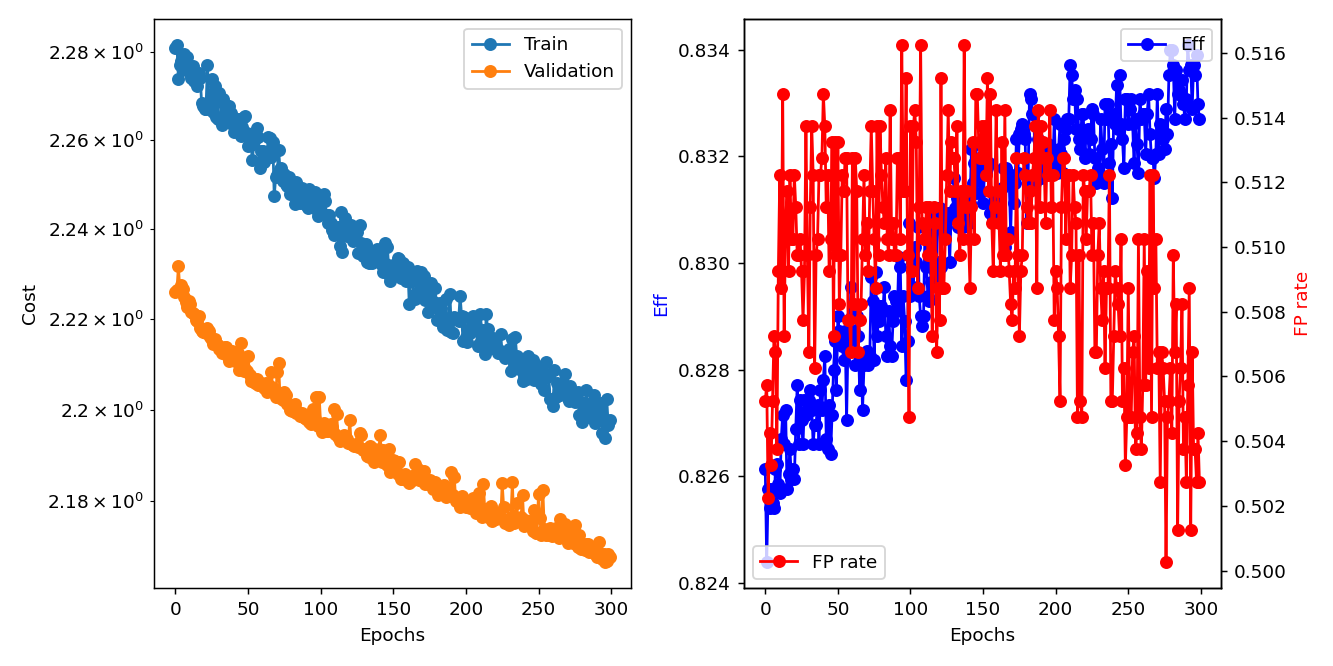

In [18]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [20]:
##quit()

